In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import numpy as np
import random
import matplotlib.pyplot as plt
import pip
pip.main(['install','seaborn'])
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from keras.applications import DenseNet121, VGG19
from keras.models import Model
from keras.layers import Dense, Flatten, Dropout, LeakyReLU, GlobalAveragePooling2D, Conv2D
from keras.optimizers import Adam
from keras.losses import BinaryFocalCrossentropy
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
# https://keras.io/api/applications/#usage-examples-for-image-classification-models
modelclass = '2'
suffix = 'INST2'
iterations = 5
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze the first 8 layers of the base model
for layer in base_model.layers[:10]:
    layer.trainable = False

# for layer in base_model.layers:
#     layer.trainable = False

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024)(x)
x = LeakyReLU(negative_slope=0.01)(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.001), 
              loss=BinaryFocalCrossentropy(), 
              metrics=['accuracy'])

# # Unfreeze some of the top layers of the base model
# for layer in base_model.layers[-10:]:
#     layer.trainable = True

# Recompile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=1e-5), 
              loss=BinaryFocalCrossentropy(), 
              metrics=['accuracy'])

model.summary()

# Load training and validation data
base_dir = '../../../FoundationNIH/Data/Arrays/'
class_dir = 'Converted Arrays/'
train_images = np.load(os.path.join(base_dir, 'train_images.npy'))
train_labels = np.load(os.path.join(class_dir, f'train_labels_class{modelclass}.npy'))
val_images = np.load(os.path.join(base_dir, 'val_images.npy'))
val_labels = np.load(os.path.join(class_dir, f'val_labels_class{modelclass}.npy'))

# Ensure the images have the correct shape (num_samples, height, width, channels)
if len(train_images.shape) == 3:
    train_images = np.expand_dims(train_images, axis=-1)
    train_images = np.repeat(train_images, 3, axis=-1)

if len(val_images.shape) == 3:
    val_images = np.expand_dims(val_images, axis=-1)
    val_images = np.repeat(val_images, 3, axis=-1)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels.flatten())
class_weights = {i: class_weights[i] for i in range(len(class_weights))}

print("Initial class weights:", class_weights)

# Add EarlyStopping and ReduceLROnPlateau callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-7)

# Path to save the best model
best_model_path = f'Models/class{suffix}{modelclass}temp.keras'
model_checkpoint = ModelCheckpoint(best_model_path, monitor='val_loss', save_best_only=True, mode='min')

# Train the model x times and save the best model
best_val_loss = float('inf')
for i in range(iterations):
    print(f"Training iteration {i+1}/{iterations}")
    history = model.fit(train_images, train_labels,
                        epochs=50,
                        batch_size=32,
                        validation_data=(val_images, val_labels),
                        class_weight=class_weights,
                        callbacks=[early_stopping, reduce_lr, model_checkpoint])
    
    # Load the best model from this iteration
    model.load_weights(best_model_path)
    val_loss = min(history.history['val_loss'])
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        model.save(f'Models/class_{suffix}{modelclass}_overallbest.keras')

print("Training Complete")

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


Requirement already satisfied: seaborn in /opt/conda/lib/python3.11/site-packages (0.13.2)

Requirement already satisfied: numpy!=1.24.0,>=1.20 in /opt/conda/lib/python3.11/site-packages (from seaborn) (1.26.4)

Requirement already satisfied: pandas>=1.2 in /opt/conda/lib/python3.11/site-packages (from seaborn) (2.2.3)

Requirement already satisfied: matplotlib!=3.6.1,>=3.4 in /opt/conda/lib/python3.11/site-packages (from seaborn) (3.9.3)

Requirement already satisfied: contourpy>=1.0.1 in /opt/conda/lib/python3.11/site-packages (from matplotlib!=3.6.1,>=3.4->seaborn) (1.3.1)

Requirement already satisfied: cycler>=0.10 in /opt/conda/lib/python3.11/site-packages (from matplotlib!=3.6.1,>=3.4->seaborn) (0.12.1)

Requirement already satisfied: fonttools>=4.22.0 in /opt/conda/lib/python3.11/site-packages (from matplotlib!=3.6.1,>=3.4->seaborn) (4.55.3)

Requirement already satisfied: kiwisolver>=1.3.1 in /opt/conda/lib/python3.11/site-packages (from matplotlib!=3.6.1,>=3.4->seaborn) (1.4.7)

Requirement already satisfied: packaging>=20.0 in /opt/conda/lib/python3.11/site-packages (from matplotlib!=3.6.1,>=3.4->seaborn) (24.2)

Requirement already satisfied: pillow>=8 in /opt/conda/lib/python3.11/site-packages (from matplotlib!=3.6.1,>=3.4->seaborn) (10.4.0)

Requirement already satisfied: pyparsing>=2.3.1 in /opt/conda/lib/python3.11/site-packages (from matplotlib!=3.6.1,>=3.4->seaborn) (3.2.0)

Requirement already satisfied: python-dateutil>=2.7 in /opt/conda/lib/python3.11/site-packages (from matplotlib!=3.6.1,>=3.4->seaborn) (2.9.0.post0)

Requirement already satisfied: pytz>=2020.1 in /opt/conda/lib/python3.11/site-packages (from pandas>=1.2->seaborn) (2023.3)

Requirement already satisfied: tzdata>=2022.7 in /opt/conda/lib/python3.11/site-packages (from pandas>=1.2->seaborn) (2024.2)

Requirement already satisfied: six>=1.5 in /opt/conda/lib/python3.11/site-packages (from python-dateutil>=2.7->matplotlib!=3.6.1,>=3.4->seaborn) (1.17.0)

I0000 00:00:1736874265.711666    9561 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1736874265.767885    9561 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1736874265.771349    9561 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1736874265.775414    9561 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 20,550,721 (78.39 MB)

 Trainable params: 18,815,233 (71.77 MB)

 Non-trainable params: 1,735,488 (6.62 MB)

Initial class weights: {0: 0.6267995570321152, 1: 2.4716157205240177}
Training iteration 1/5
Epoch 1/50


I0000 00:00:1736874273.862024    9593 service.cc:146] XLA service 0x7fc1740072c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1736874273.862063    9593 service.cc:154]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1736874302.214339    9593 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


176/177 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - accuracy: 0.5322 - loss: 0.3543

E0000 00:00:1736874374.025000    9594 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1736874374.261219    9594 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1736874376.313767    9594 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1736874376.634427    9594 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 512ms/step - accuracy: 0.5321 - loss: 0.3535

E0000 00:00:1736874408.205407    9595 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1736874408.427783    9595 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1736874409.937764    9595 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1736874410.238657    9595 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


177/177 ━━━━━━━━━━━━━━━━━━━━ 143s 634ms/step - accuracy: 0.5321 - loss: 0.3528 - val_accuracy: 0.5565 - val_loss: 0.1717 - learning_rate: 1.0000e-05
Epoch 2/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 74s 407ms/step - accuracy: 0.5590 - loss: 0.1715 - val_accuracy: 0.7527 - val_loss: 0.1612 - learning_rate: 1.0000e-05
Epoch 3/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 71s 399ms/step - accuracy: 0.6352 - loss: 0.1637 - val_accuracy: 0.4523 - val_loss: 0.1859 - learning_rate: 1.0000e-05
Epoch 4/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 72s 407ms/step - accuracy: 0.6843 - loss: 0.1531 - val_accuracy: 0.8092 - val_loss: 0.1385 - learning_rate: 1.0000e-05
Epoch 5/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 71s 399ms/step - accuracy: 0.7395 - loss: 0.1472 - val_accuracy: 0.7014 - val_loss: 0.1545 - learning_rate: 1.0000e-05
Epoch 6/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 71s 399ms/step - accuracy: 0.7562 - loss: 0.1401 - val_accuracy: 0.6952 - val_loss: 0.1559 - learning_rate: 1.0000e-05
Epoch 7/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 72s 409ms/step -

21/24 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.8196 - loss: 0.1180

E0000 00:00:1736876942.323910    9593 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1736876942.551922    9593 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1736876944.235229    9593 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1736876944.545109    9593 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


24/24 ━━━━━━━━━━━━━━━━━━━━ 17s 720ms/step - accuracy: 0.8217 - loss: 0.1178
Test Loss: 0.1153678223490715
Test Accuracy: 0.8317880630493164
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 181ms/step


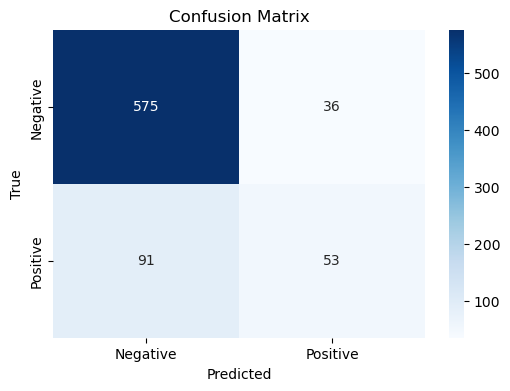

E0000 00:00:1736876955.844153    9596 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1736876956.042369    9596 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1736876956.538647    9596 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1736876956.791812    9596 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


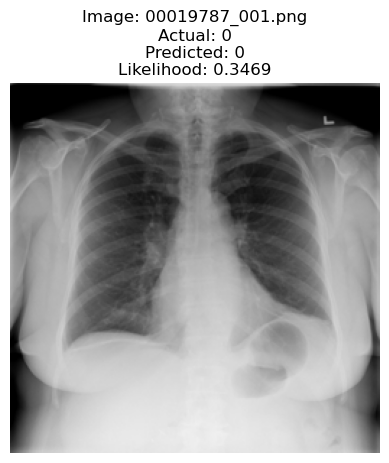

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


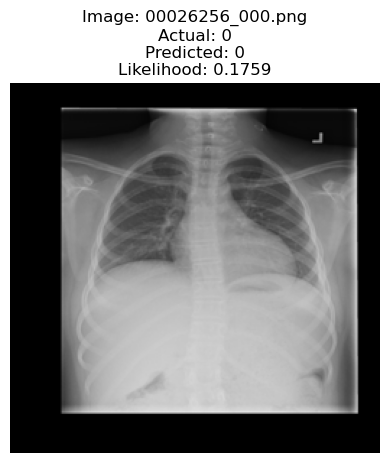

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


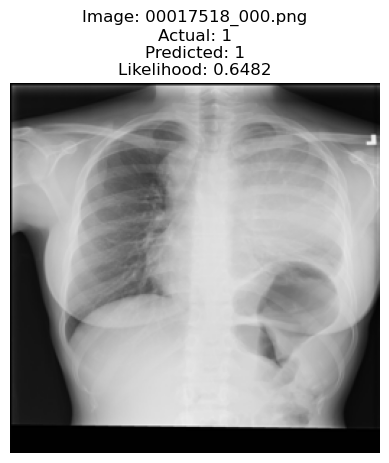

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


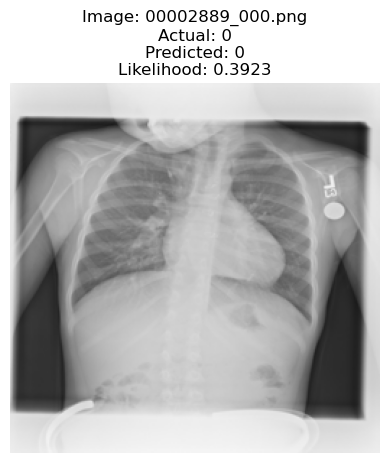

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


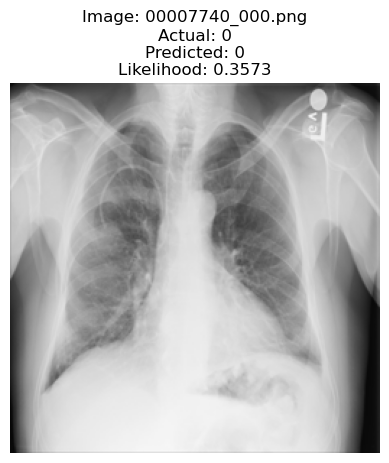

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


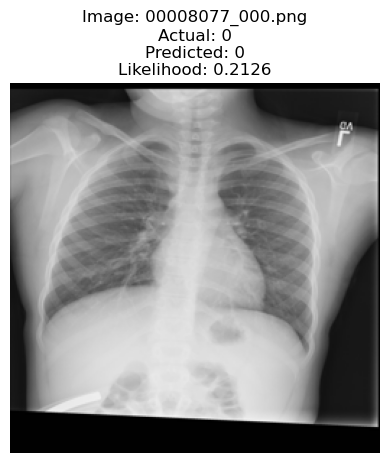

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


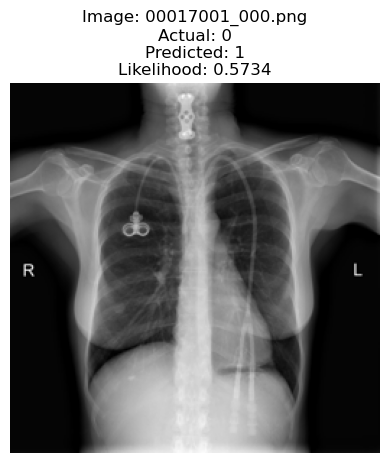

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


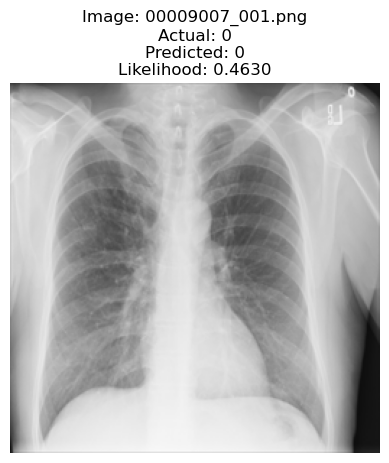

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


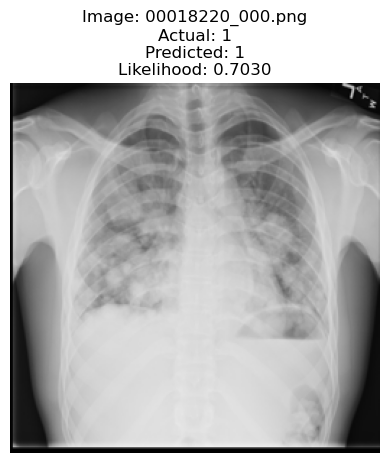

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


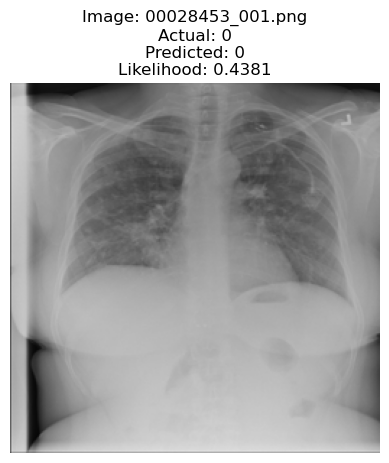

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


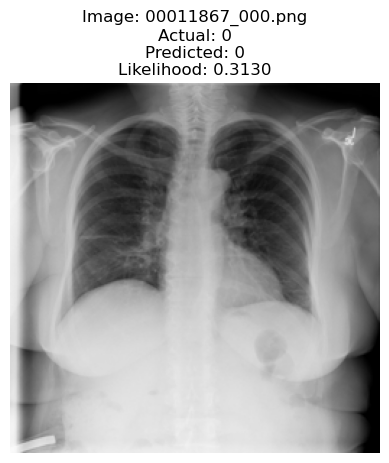

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


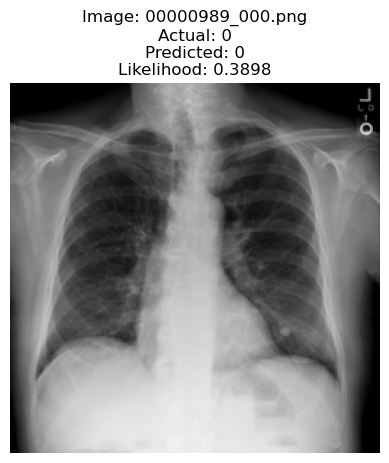

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


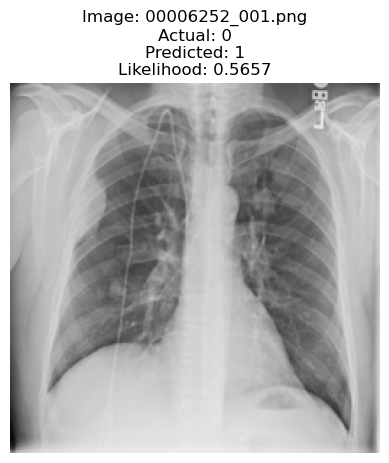

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


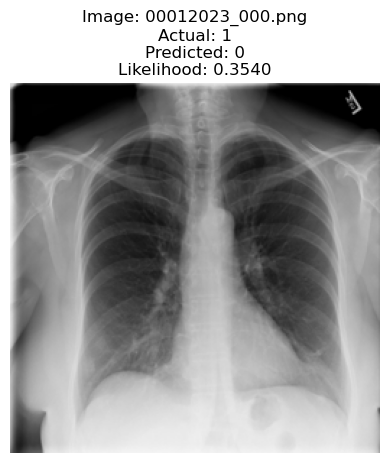

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


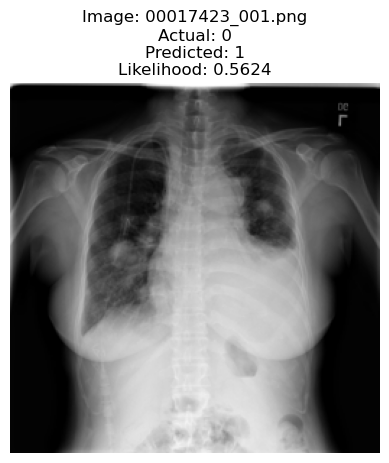

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


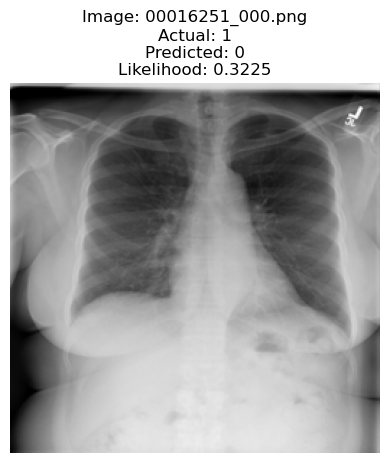

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


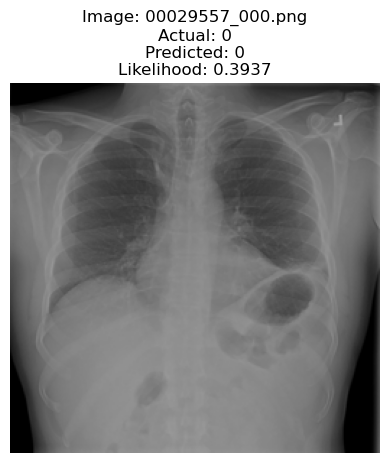

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


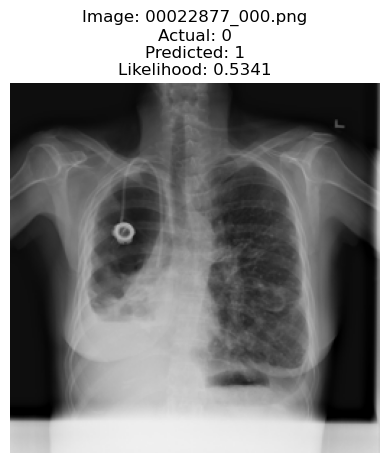

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


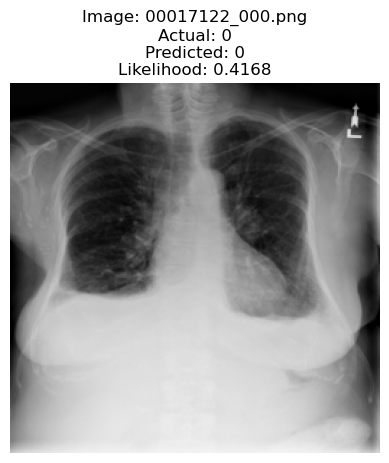

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


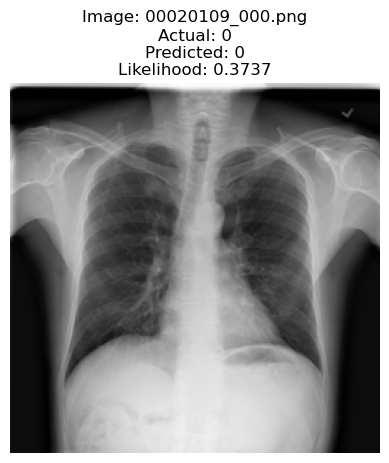

In [2]:

test_images = np.load(os.path.join(base_dir, 'test_images.npy'))
test_labels = np.load(os.path.join(class_dir, f'test_labels_class{modelclass}.npy'))
test_image_names = np.load(os.path.join(base_dir, 'test_image_names.npy'), allow_pickle=True)

if len(test_images.shape) == 3:
    test_images = np.expand_dims(test_images, axis=-1)
    test_images = np.repeat(test_images, 3, axis=-1)

test_loss, test_accuracy = model.evaluate(test_images, test_labels, verbose=1)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

y_pred = model.predict(test_images)
y_pred_binary = (y_pred > 0.5).astype(int)

cm = confusion_matrix(test_labels, y_pred_binary)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

def display_image_with_predictions(image, image_name, actual_label, predicted_label, likelihood):
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(f"Image: {image_name}\nActual: {actual_label}\nPredicted: {predicted_label}\nLikelihood: {likelihood:.4f}")
    plt.axis('off')
    plt.show()

num_samples = 20
indices = random.sample(range(test_images.shape[0]), num_samples)

for idx in indices:
    image = test_images[idx]
    image_name = test_image_names[idx]
    actual_label = test_labels[idx][0]
    image_expanded = np.expand_dims(image, axis=0)
    prediction = model.predict(image_expanded)[0][0]
    
    threshold = 0.5
    predicted_label = int(prediction > threshold)
    likelihood = prediction
    
    display_image_with_predictions(image, image_name, actual_label, predicted_label, likelihood)